# Environment

In [1]:
import torchaudio
import numpy as np
from torch import Tensor
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import find_peaks
from helpers.path_utils import get_base_dir
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks, decimate
from helpers.plot import plot_wavelet_spectrogram, plot_audio_fft
from helpers.transform import apply_bandpass_filter, min_max_scale

# Raw Heartbeat

Sample rate:  4000


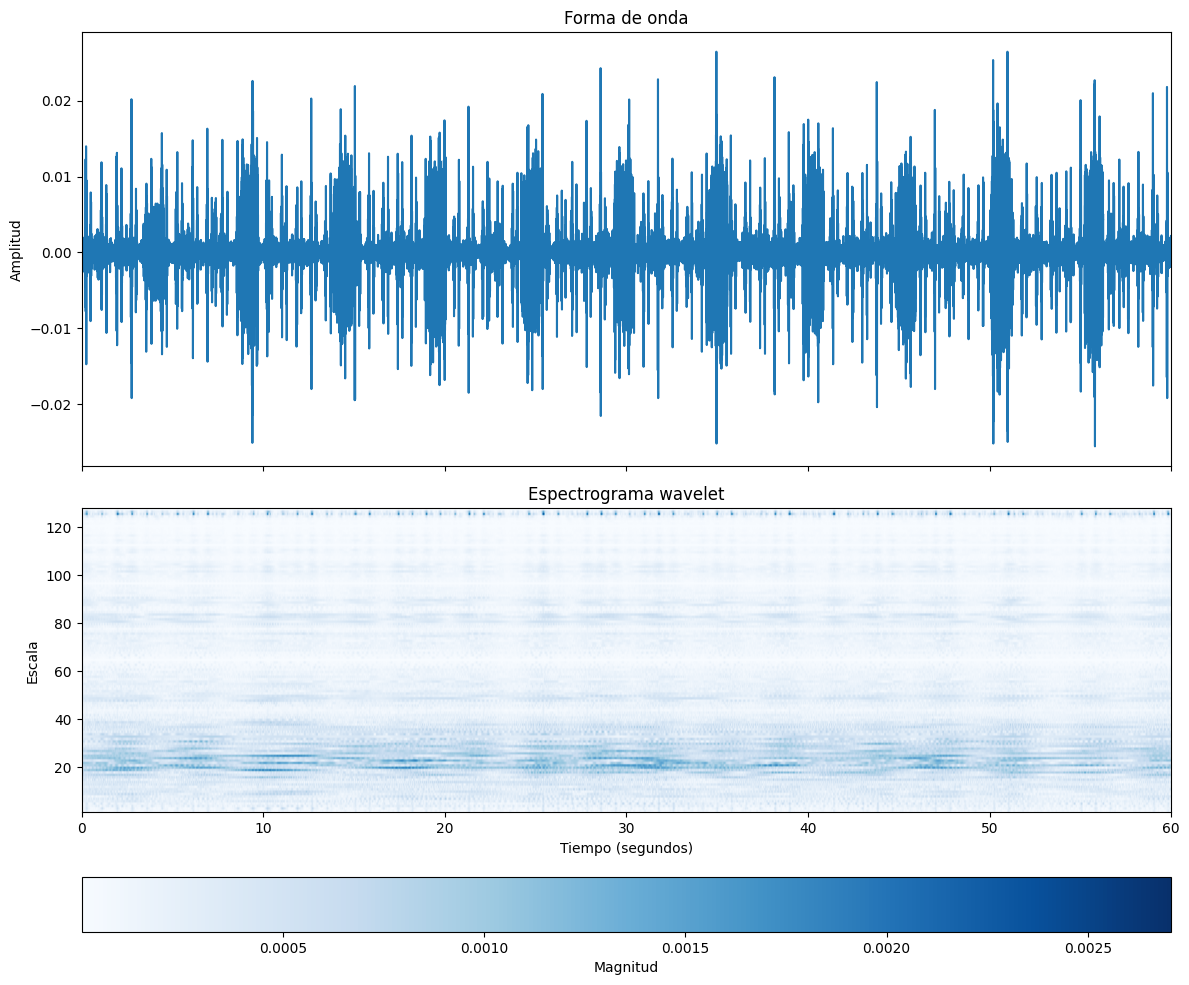

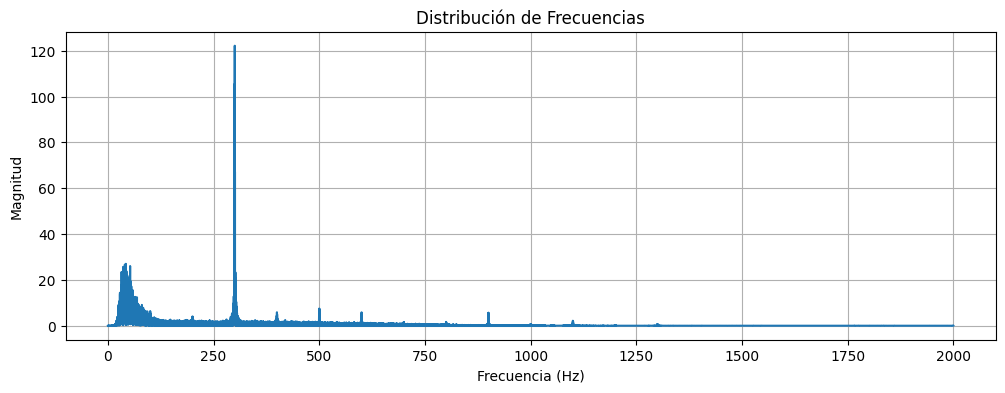

In [2]:
AUDIO_NAME = "Eko Recording Sound Export 08_17_2024 3_00 PM.wav"
audio_dir = get_base_dir().joinpath("data", "digital", AUDIO_NAME)

audio, sample_rate = torchaudio.load(str(audio_dir))
print("Sample rate: ", sample_rate)

plot_wavelet_spectrogram(audio.numpy(), sample_rate)#, downsample_factor=1)
plot_audio_fft(audio.numpy(), sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Focus on synthetic frequency

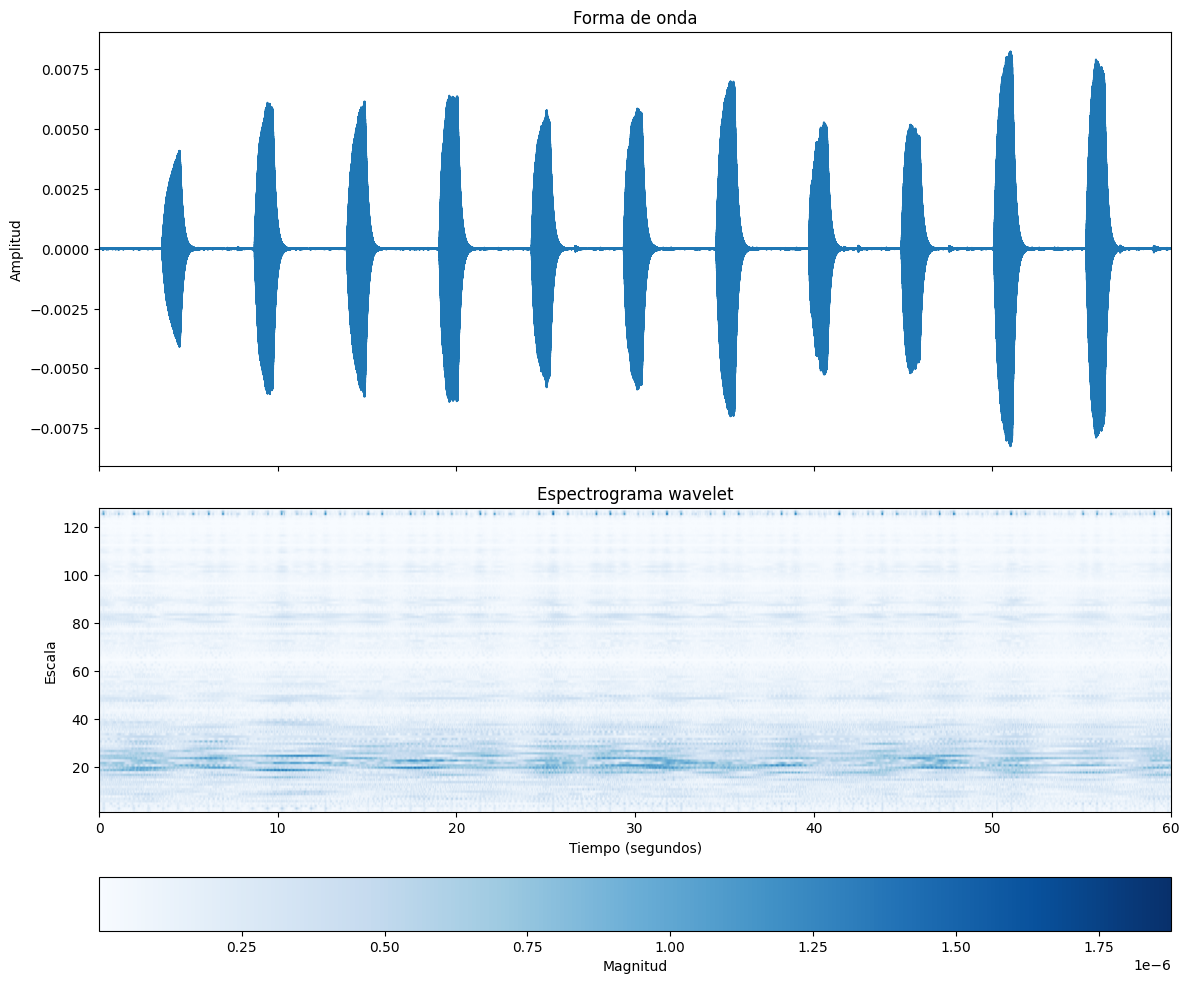

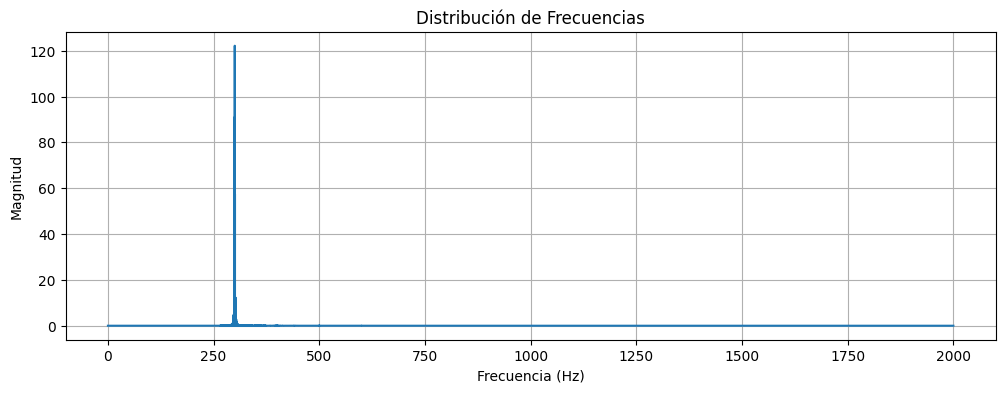

In [3]:
SYNTHETIC_FREQ = 300
low_cutoff = SYNTHETIC_FREQ - 1
high_cutoff = SYNTHETIC_FREQ + 1

filtered_audio = apply_bandpass_filter(
    audio, sample_rate, low_cutoff, high_cutoff
)

plot_wavelet_spectrogram(filtered_audio.numpy(), sample_rate)#, downsample_factor=1)
plot_audio_fft(filtered_audio.numpy(), sample_rate)

Audio(filtered_audio, rate=sample_rate, autoplay=True)

# Absolute signal

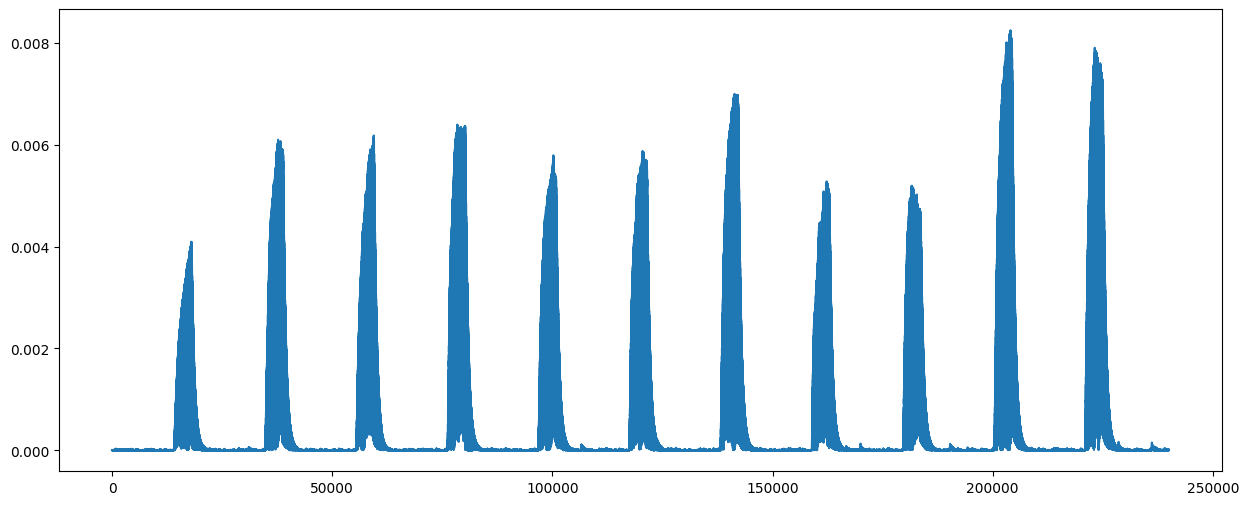

In [4]:
abs_filtered = filtered_audio.abs()

plt.figure(figsize=(15, 6))
plt.plot(abs_filtered.squeeze())

# Downsample it

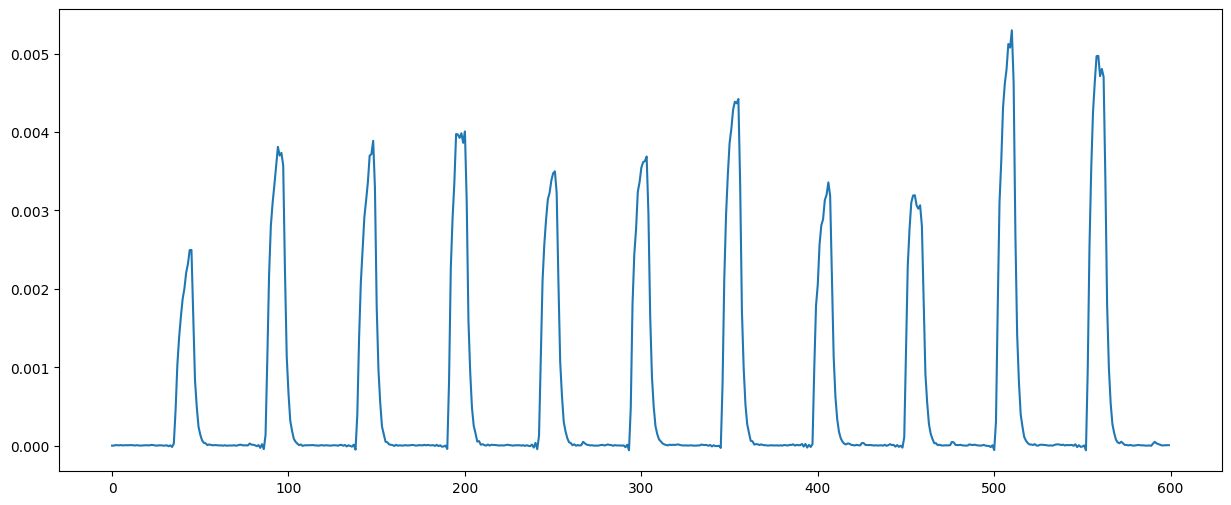

In [5]:
DOWNSAMPLE_FACTOR = 400

downsampled = decimate(abs_filtered, DOWNSAMPLE_FACTOR)

plt.figure(figsize=(15, 6))
plt.plot(downsampled.squeeze())

# Smooth it

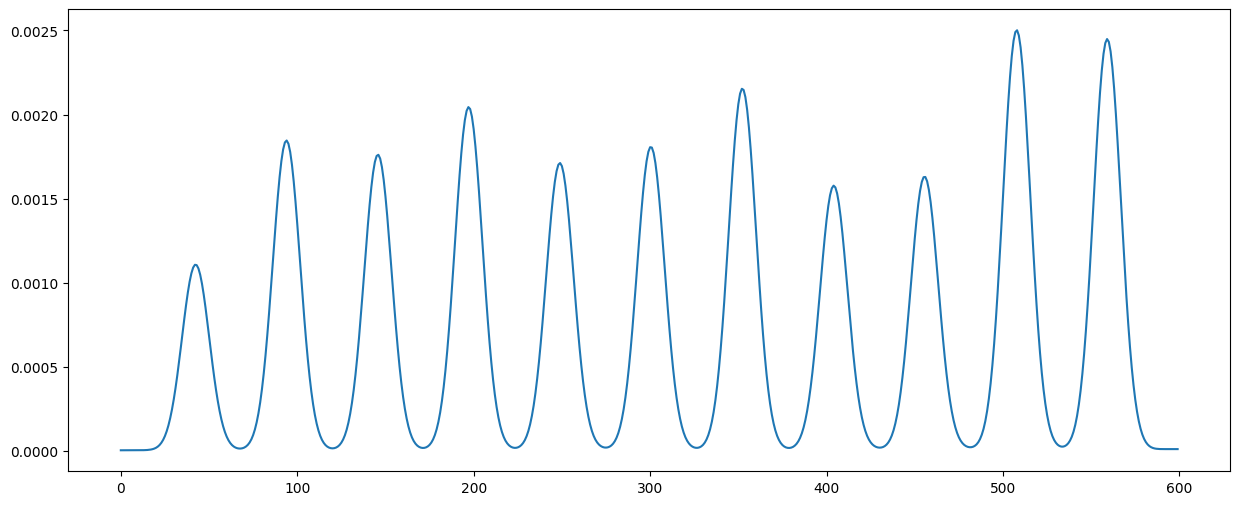

In [6]:
SIGMA_SMOOTH = 7

smoothed = gaussian_filter1d(downsampled, sigma=SIGMA_SMOOTH)

plt.figure(figsize=(15, 6))
plt.plot(smoothed.squeeze())

# Find peaks where signal changes

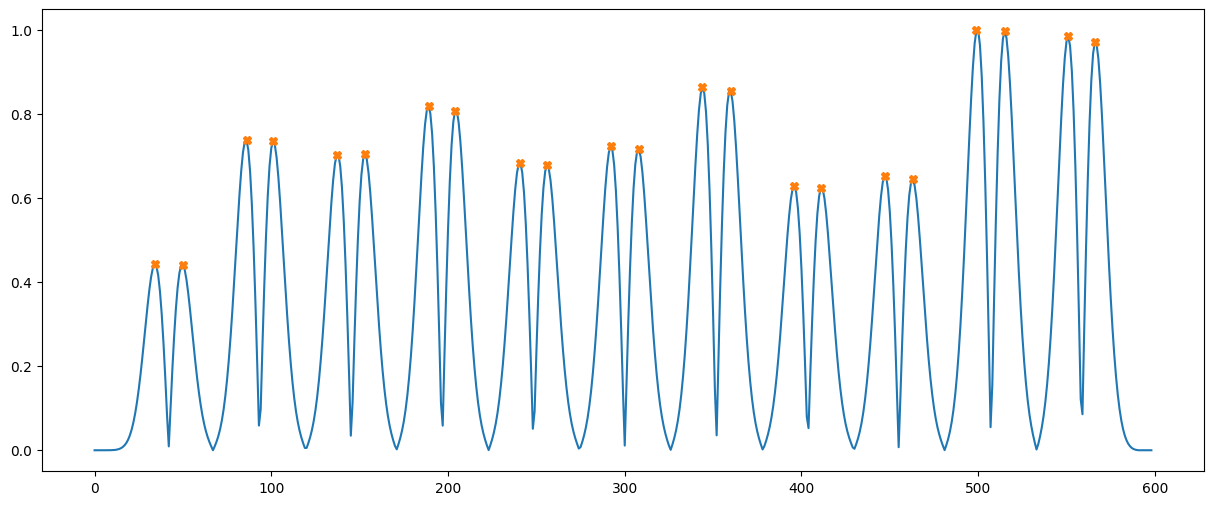

In [7]:
PEAKS_HEIGHT = 0.3
PEAKS_PROMINENCE = 0.0001

smoothed_diff = np.abs(np.diff(smoothed).squeeze())
smoothed_diff = min_max_scale(Tensor(smoothed_diff))
peaks, _ = find_peaks(smoothed_diff, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(15, 6))
plt.plot(smoothed_diff)
plt.plot(peaks, smoothed_diff[peaks], "X")

# Upsample those peaks in the raw audio signal

Peaks found in downsampled signal: [ 34  50  86 101 137 153 189 204 241 256 292 308 344 360 396 411 447 463
 499 515 551 566]
Peaks in real signal: [ 13600  20000  34400  40400  54800  61200  75600  81600  96400 102400
 116800 123200 137600 144000 158400 164400 178800 185200 199600 206000
 220400 226400]


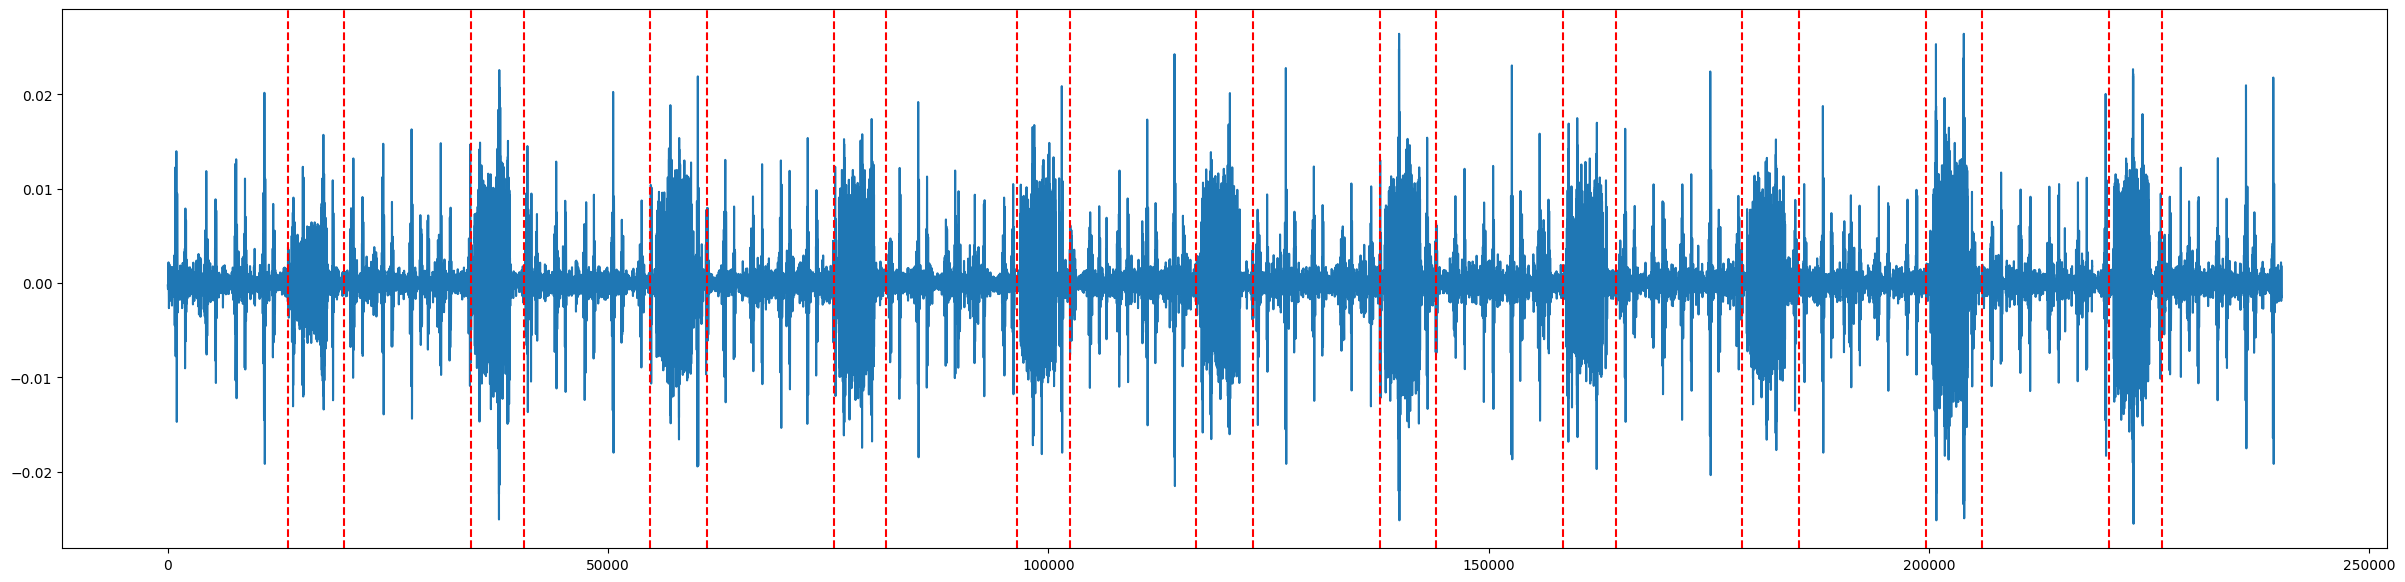

In [8]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR
print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")

plt.figure(figsize=(30, 7))
plt.plot(audio.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color='red', linestyle='--')

plt.show()

# Split signal

In [9]:
split_points = np.concatenate(([0], upsampled_peaks, [audio.shape[1]]))

audio_tensor = audio.squeeze()
segments = [
    audio_tensor[split_points[i] : split_points[i + 1]]
    for i in range(len(split_points) - 1)
]

for i, segment in enumerate(segments):
    duration = len(segment) / sample_rate
    to_print = f"#{i+1}: {duration:.2f}s"

    if duration < 2:
        to_print += " trigger"
    else:
        to_print += " segment"

    # to_print += f": {segment}"
    print(to_print)

#1: 3.40s segment
#2: 1.60s trigger
#3: 3.60s segment
#4: 1.50s trigger
#5: 3.60s segment
#6: 1.60s trigger
#7: 3.60s segment
#8: 1.50s trigger
#9: 3.70s segment
#10: 1.50s trigger
#11: 3.60s segment
#12: 1.60s trigger
#13: 3.60s segment
#14: 1.60s trigger
#15: 3.60s segment
#16: 1.50s trigger
#17: 3.60s segment
#18: 1.60s trigger
#19: 3.60s segment
#20: 1.60s trigger
#21: 3.60s segment
#22: 1.50s trigger
#23: 3.40s segment


# All wrapped in one function

In [12]:
from helpers.transform import TrimAfterTrigger

tat = TrimAfterTrigger()

final_segments = tat.transform(
    audio_dir=audio_dir,
    synthetic_freq=SYNTHETIC_FREQ,
    downsample_factor=DOWNSAMPLE_FACTOR,
    sigma_smooth=SIGMA_SMOOTH,
    peaks_height=PEAKS_HEIGHT,
    peaks_prominence=PEAKS_PROMINENCE,
)

total_duration = 0
for i, segment in enumerate(final_segments[0]):
    segment = segment.squeeze()
    duration = len(segment) / sample_rate
    total_duration += duration

    print(f"#{i+1} {duration}s ({total_duration:.2f}s acum)")
    # plt.plot(segment)
    # plt.show()

#1 3.4s (3.40s acum)
#2 1.6s (5.00s acum)
#3 3.6s (8.60s acum)
#4 1.5s (10.10s acum)
#5 3.6s (13.70s acum)
#6 1.6s (15.30s acum)
#7 3.6s (18.90s acum)
#8 1.5s (20.40s acum)
#9 3.7s (24.10s acum)
#10 1.5s (25.60s acum)
#11 3.6s (29.20s acum)
#12 1.6s (30.80s acum)
#13 3.6s (34.40s acum)
#14 1.6s (36.00s acum)
#15 3.6s (39.60s acum)
#16 1.5s (41.10s acum)
#17 3.6s (44.70s acum)
#18 1.6s (46.30s acum)
#19 3.6s (49.90s acum)
#20 1.6s (51.50s acum)
#21 3.6s (55.10s acum)
#22 1.5s (56.60s acum)
#23 3.4s (60.00s acum)
